In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Визуализация активности генов
def plot_gene_dynamics(df, title="Генетическая динамика", genes=None):
    """
    Визуализирует динамику экспрессии генов и энергии клетки, 
    масштабируя энергию так, чтобы её максимум был в 1/4 от максимума по генам.

    Аргументы:
    - df: DataFrame с результатами симуляции
    - title: заголовок графика
    - genes: словарь с ключами - названиями генов, и значениями - цветами линий
             Пример: {"ENGSENS": "blue", "HARVEST": "green"}
    """
    if genes is None:
        genes = {"ENGSENS": "blue", "FOODSENS": "red", "HARVEST": "green", "DIVISION": "purple"}

    # 1) Находим максимум по генам
    max_expr = 0.0
    for g in genes:
        if g in df.columns:
            max_expr = max(max_expr, df[g].max())

    if max_expr == 0:
        scale = 1.0
    else:
        # 2) Находим максимум энергии и считаем scale так,
        # чтобы max_energy*scale = max_expr/4
        max_energy = df["Energy"].max()
        scale = (max_expr / 4) / max_energy if max_energy != 0 else 1.0

    # 3) Создаём фигуру
    fig, ax = plt.subplots(figsize=(12, 6))

    # 4) Масштабированное поле энергии
    ax.fill_between(
        df["Tick"],
        df["Energy"] * scale,
        color="orange", alpha=0.2,
        label=f"Energy (scaled ×{scale:.2f})"
    )

    # 5) Линии активности генов
    for gene, color in genes.items():
        if gene in df.columns:
            ax.plot(df["Tick"], df[gene], label=gene, color=color, linewidth=2)

    # 6) Дополнительные базовые линии
    # ax.axhline(max_expr / 4, color='gray', linestyle=':', linewidth=0.5,
    #            label="Max energy on ¼ of max gene expr")
    ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

    ax.set_title(title)
    ax.set_xlabel("Tick")
    ax.set_ylabel("Уровень (нормировано)")
    ax.legend(loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    """
    Симуляция регуляции транскрипции генов в искусственной клетке.

    Функция моделирует процессы транскрипции и экспрессии генов, регуляцию их активности, накопление белков,
    обмен энергии, влияние токсинов и возможное деление клетки. Возвращает таблицу со значениями уровней экспрессии
    генов (TPM), уровнем энергии и токсинов на каждом такте.

    Параметры:
    ----------
    ticks : int, по умолчанию 50
        Количество тактов (временных шагов) симуляции.

    initial_food : float, по умолчанию 1.0
        Начальное количество доступной пищи (внешний ресурс).

    initial_energy : float, по умолчанию 1.0
        Начальный уровень энергии клетки.

    energy_cost : float, по умолчанию 0.01
        Энергозатраты на каждый TPM гена в такт.

    receptors, metabolism, kinases, cell_cycle, division : dict
        Словари с описаниями генов, сгруппированных по функциям. 
        Формат записи каждого гена:
            "ИмяГена": (
                порог_активации: int,
                режим: "qual" или "quan",
                промотор: "wk" | "av" | "st",     # сила промотора
                энхансер: "wk" | "av" | "st",     # сила энхансера
                условия_включения: list[str],     # список выражений на Python
                условия_выключения: list[str],    # список выражений на Python
                функция: None или (тип, значение)
            )
        Типы функций:
            - ("energy", x): генерация энергии
            - ("process", x): переработка белков в энергию
            - ("RNAdigest", x): переработка TPM в энергию
            - ("div", x): деление клетки

    toxins : dict
        Описание действующих токсинов:
            { "ToxinName": (σ: float, (target_param: str, base_effect: float)) }
        target_param — "energy" или "TPM". Значение эффекта рассчитывается сигмоидальной функцией.

    toxin_k : float, по умолчанию 1
        Коэффициент чувствительности к токсинам.

    Возвращаемое значение:
    ----------------------
    pd.DataFrame
        Таблица с результатами симуляции по тактам. Содержит:
        - Tick: номер такта
        - Food: уровень пищи
        - <ToxinName>: уровни каждого токсина (σ)
        - Energy: текущий уровень энергии
        - <GeneName>: уровень экспрессии каждого гена (TPM)

    Особенности:
    ------------
    - Экспрессия гена (TPM) растет в зависимости от промотора и ограничивается энхансером.
    - Ген активируется, если выполняются все условия включения и не выполняется ни одно из условий выключения.
    - Деактивация гена происходит с задержкой в один такт.
    - Белок начинает действовать с **следующего** такта после экспрессии.
    - Токсины могут снижать уровень энергии или ограничивать рост TPM.
    - Поддерживается неограниченное количество генов.
    - Модель позволяет использовать регуляторные связи между генами через условия активации/деактивации.
    - Клетка погибает, если энергия падает ниже -3.
    - Единицы измерения TPM — условные, приближенные к нормализованной экспрессии.

    Пример визуализации:
    --------------------
    import matplotlib.pyplot as plt
    df.plot(x="Tick", y=["Energy", "CDK1", "DIVISION"], figsize=(12,6))
    plt.grid(True)
    plt.show()
    """

In [3]:
# Токсины, с отладочным кодом (добавляем инфо о штрафах в таблицу)
def simulate_cell_with_proteins_and_rna(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = {},           # {"ToxinName": (sigma, (param, base_eff)), ...}
    toxin_k: float = 1       # коэффициент k в формуле токсинов
) -> pd.DataFrame:
    """
    Симуляция с учётом токсинов. В результирующем DataFrame после Food
    будут колонки с уровнями токсинов (sigma).
    """

    def cond_all(conds, vars_):
        return all(eval(c, {}, vars_) for c in conds)

    def cond_any(conds, vars_):
        return any(eval(c, {}, vars_) for c in conds)

    def grow_and_cap(expr, promoter, enhancer):
        if promoter == 'wk':
            new = expr + 1
        elif promoter == 'av':
            new = expr * 2
        elif promoter == 'st':
            new = expr * 4
        else:
            new = expr
        cap = {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
        return min(new, cap)

    def toxin_effect(sigma, base_effect=0.4, k=0.01):
        return (2 * base_effect) / (1 + np.exp(-k * sigma))

    # собираем все гены
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())

    # инициализация
    gene_expr   = {g: 1 for g in gene_list}
    gene_status = {g: "inactive" for g in gene_list}
    gene_prot   = {g: 0.0 for g in gene_list}
    deact_delay = {g: False for g in gene_list}

    energy, food = initial_energy, initial_food
    records = []

    for tick in range(ticks):
        prev_expr   = gene_expr.copy()
        prev_status = gene_status.copy()
        prev_prot   = gene_prot.copy()

        # --- расчет штрафов от токсинов ---
        tox_penalties = {}
        # и уровней для логирования
        tox_levels = {}
        for name, (sigma, (param, base_eff)) in toxins.items():
            tox_levels[name] = sigma
            eff = toxin_effect(sigma, base_eff, toxin_k)
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff

        # сразу вычитаем энергетический штраф
        if "energy" in tox_penalties:
            energy -= tox_penalties["energy"]

        # локальная среда
        local = {"Energy": energy, "Food": food}
        local.update(prev_status)

        # off_cond этого такта
        had_off = {
            g: cond_any(all_genes[g][5], local)
            for g in gene_list
        }

        # 1) Рост TPM + сброс
        new_expr = {}
        for g, (thr, mode, prom, enh, on_cond, off_cond, func) in all_genes.items():
            if cond_all(on_cond, local) and not had_off[g]:
                val = grow_and_cap(prev_expr[g], prom, enh)
            else:
                val = 1
            # применяем штраф TPM
            tpen = tox_penalties.get("TPM", 0.0)
            # new_expr[g] = max(1, val - tpen)
            tpen = 1 - min(tpen, 1)
            new_expr[g] = max(1, val * tpen)

        # 2) Статусы с задержкой деактивации
        new_status = {}
        for g, (thr, mode, prom, enh, on_cond, off_cond, func) in all_genes.items():
            if deact_delay[g]:
                new_status[g]  = "inactive"
                deact_delay[g] = False
                continue
            if prev_status[g] == "active":
                if had_off[g]:
                    new_status[g]  = "active"
                    deact_delay[g] = True
                else:
                    new_status[g]  = "active"
            else:
                if (not had_off[g]
                    and cond_all(on_cond, local)
                    and new_expr[g] >= thr):
                    new_status[g] = "active"
                else:
                    new_status[g] = "inactive"

        # 3) Наращиваем белок
        gene_prot = {g: prev_prot[g] + prev_expr[g] for g in gene_list}

        # 4) Функции активных генов
        division_happened = False
        for g, (thr, mode, prom, enh, on_cond, off_cond, func) in all_genes.items():
            if not func or prev_status[g] != "active" or prev_expr[g] < thr:
                continue
            ftype, val = func
            eff = prev_expr[g] if mode == "quan" else thr

            if ftype == "energy":
                energy += eff * val
            elif ftype == "process":
                to_proc, rem = eff, 0.0
                for tgt in gene_list:
                    if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                        continue
                    cut = min(gene_prot[tgt], to_proc)
                    gene_prot[tgt] -= cut
                    to_proc       -= cut
                    rem           += cut
                energy += rem * val
            elif ftype == "RNAdigest":
                to_dig, dig = eff, 0.0
                for tgt in gene_list:
                    if to_dig <= 0:
                        break
                    av = new_expr[tgt] - 1
                    if av <= 0:
                        continue
                    cut = min(av, to_dig)
                    new_expr[tgt] -= cut
                    to_dig       -= cut
                    dig          += cut
                energy += dig * val
            elif ftype == "div":
                energy -= val
                division_happened = True

        # 5) Деление
        if division_happened:
            for g in gene_list:
                new_expr[g]    = 1
                new_status[g]  = "inactive"
                gene_prot[g]   = 0.0
                deact_delay[g] = False

        # 6) Энергозатраты
        energy -= sum(new_expr.values()) * energy_cost

        # 7) Логирование: вставляем tox_levels сразу после Food
        rec = {"Tick": tick, "Food": round(food,2)}
        # уровни σ
        rec.update({name: tox_levels[name] for name in toxins})
        # штрафы (можно закомментировать)
        # rec["Penalty_energy"] = round(tox_penalties["energy"],4)
        # rec["Penalty_TPM"]    = round(1 - tpen,4)
        # энергия и ген. экспрессии
        rec["Energy"] = round(energy,2)
        rec.update(new_expr)
        records.append(rec)

        # 8) Подготовка
        gene_expr, gene_status = new_expr, new_status
        food = initial_food
        if energy <= -3:
            print(f"Клетка погибла на такте {tick}, energy={energy:.2f}")
            break

    return pd.DataFrame(records)

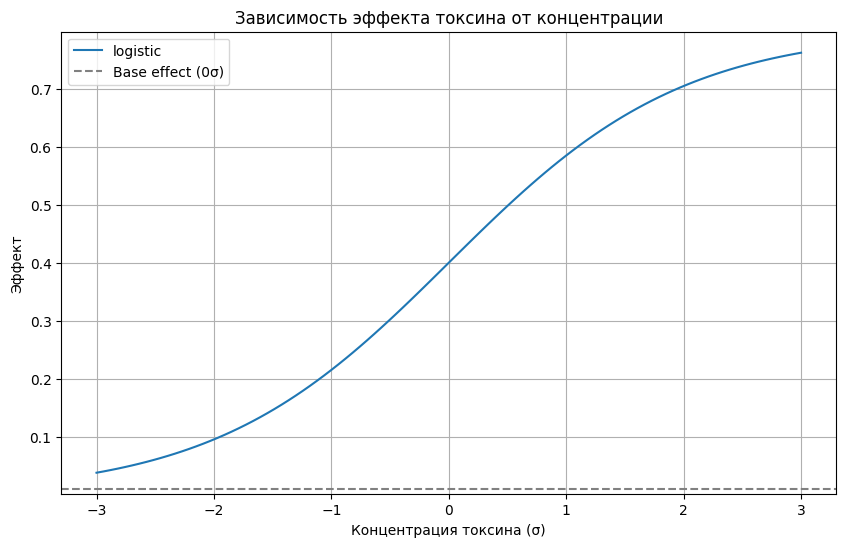

In [4]:
def toxin_effect(sigma, model="exponential", base_effect=0.4, k=0.01):
    if model == "linear":
        return base_effect * (1 + k * sigma)
    elif model == "exponential":
        return base_effect * np.exp(k * sigma)
    elif model == "logistic":
        return (2 * base_effect) / (1 + np.exp(-k * sigma))
    else:
        raise ValueError("Unknown model")

sigma = np.linspace(-3, 3, 100)
effects = {
    # "linear": toxin_effect(sigma, "linear"),
    # "exponential": toxin_effect(sigma, "exponential"),
    "logistic": toxin_effect(sigma, "logistic", k=1)
}

plt.figure(figsize=(10, 6))
for model, effect in effects.items():
    plt.plot(sigma, effect, label=model)
plt.axhline(y=0.01, color="gray", linestyle="--", label="Base effect (0σ)")
plt.xlabel("Концентрация токсина (σ)")
plt.ylabel("Эффект")
plt.title("Зависимость эффекта токсина от концентрации")
plt.legend()
plt.grid()
plt.show()

In [5]:
def toxin_effect(sigma, base_effect=0.5, k=0.01):
    return (2 * base_effect) / (1 + np.exp(-k * sigma))

sigma = 3
effects = toxin_effect(sigma, base_effect=0.9, k=1)
effects

1.71463342828038

In [6]:
# Модель без токсинов
df = simulate_cell_with_proteins_and_rna(
    ticks=5000,
    initial_food=1.0,
    initial_energy=1.0,
    energy_cost=0.003,
    # toxins={"Energotoxin": (-2, ("energy", 0.002)), "Transcriptotoxin": (-1, ("TPM", 0.005))},
    receptors={
        "ENGSENS": (16, "qual", "av", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINA1 == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "STRESSRESP":(8,  "qual", "av", "av", ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= 0", "DIVISION == 'active'"], ("energy", 0.0005)),
        "CDS1": (2,  "quan", "av", "wk", ["Energy >= -3"], [], False),
        "CDS2": (2,  "quan", "av", "av", ["Energy >= -3"], ["DIVISION == 'active'"], False),
        "CDS3": (2,  "quan", "av", "av", ["Energy >= -3"], ["DIVISION == 'active'"], False),
    },
    
    metabolism={
        "HARVEST":    (2,  "quan", "st", "st", ["Food >= -1.5", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.5", "DIVISION == 'active'"], ("energy", 0.008)),
        "AUTOPHAGY":  (2,  "quan", "av", "st", ["Energy <= -2", "FOODSENS == 'active'"], ["Energy >= 0", "DIVISION == 'active'"], ("process", 0.0015)),
        "PROTREP":    (4,  "quan", "st", "av", ["AUTOPHAGY == 'active'", "Energy <= -2"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "RNASERH": (3, "quan", "wk", "av", ["Energy > 2"], ["Energy <= -2.5"], ("RNAdigest", 0.0002)),
        "RNASEPR": (3, "quan", "wk", "av", ["Energy <= -2"], ["Energy > -1.5"], ("RNAdigest", 0.0002))
    },
    
    kinases={
        "KINA1":   (4, "qual", "st", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 1", "DIVISION == 'active'"], False),
    },
    
    cell_cycle={
        "CDK1":    (4,  "qual", "wk", "wk", ["Energy >= 1.5"], ["DIVISION == 'active'", "AUTOPHAGY == 'active'"], False),
    },
    
    division={
        "DIVISION":(16, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)

df

,Tick,Food,Energy,ENGSENS,FOODSENS,STRESSRESP,CDS1,CDS2,CDS3,HARVEST,AUTOPHAGY,PROTREP,RNASERH,RNASEPR,KINA1,CDK1,DIVISION
0,0,1.0,0.95,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1,1,1.0,1,1.0,1.0,1.0
1,1,1.0,0.87,4.0,1.0,1.0,4.0,4.0,4.0,1.0,1,1,1.0,1,1.0,1.0,1.0
2,2,1.0,0.75,8.0,1.0,1.0,4.0,8.0,8.0,1.0,1,1,1.0,1,1.0,1.0,1.0
3,3,1.0,0.57,16.0,1.0,1.0,4.0,16.0,16.0,1.0,1,1,1.0,1,1.0,1.0,1.0
4,4,1.0,0.37,16.0,1.0,1.0,4.0,16.0,16.0,1.0,1,1,1.0,1,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,1.0,-0.78,16.0,16.0,1.0,4.0,16.0,16.0,64.0,1,1,1.0,1,4.0,1.0,1.0
4996,4996,1.0,-0.70,16.0,16.0,1.0,4.0,16.0,16.0,64.0,1,1,1.0,1,4.0,1.0,1.0
4997,4997,1.0,-0.62,16.0,16.0,1.0,4.0,16.0,16.0,64.0,1,1,1.0,1,4.0,1.0,1.0
4998,4998,1.0,-0.54,16.0,16.0,1.0,4.0,16.0,16.0,64.0,1,1,1.0,1,4.0,1.0,1.0


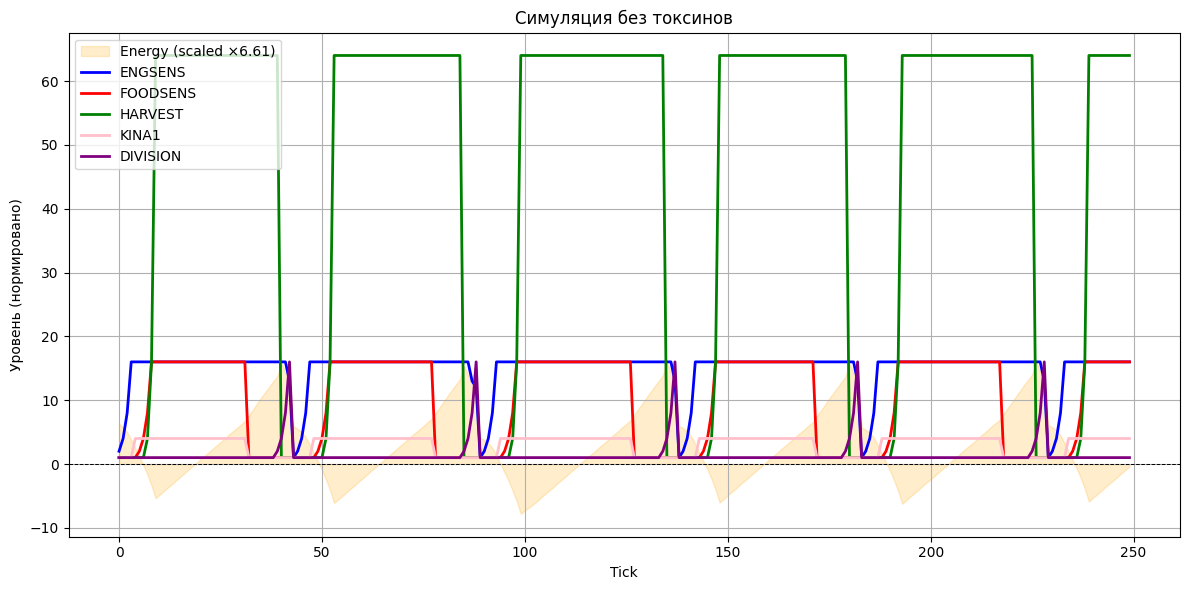

In [7]:
plot_gene_dynamics(df.iloc[:250, :], title="Симуляция без токсинов",
                   genes={"ENGSENS": "blue", 
                          "FOODSENS": "red", 
                          "HARVEST": "green",
                          "KINA1": "pink",
                          "DIVISION": "purple"})

In [8]:
# Действует сильный энерготоксин
df = simulate_cell_with_proteins_and_rna(
    ticks=250,
    initial_food=1.0,
    initial_energy=1.0,
    energy_cost=0.003,
    toxins={"Energotoxin": (0, ("energy", 0.3)), 
           "RNAtoxin": (0, ("TPM", 0.0))
           },
    receptors={
        "ENGSENS": (12, "qual", "av", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINA1 == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
    },
    
    metabolism={
        "HARVEST":    (2,  "quan", "st", "st", ["Food <= 1", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.008)),
    },
    
    kinases={
        "KINA1":   (3, "qual", "st", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > -1", "DIVISION == 'active'"], False),
    },
    
    cell_cycle={
        "CDK1":    (3,  "qual", "wk", "wk", ["Energy >= 1.5"], ["DIVISION == 'active'"], False),
    },
    
    division={
        "DIVISION":(15, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)

df.shape

Клетка погибла на такте 11, energy=-3.38


(12, 11)

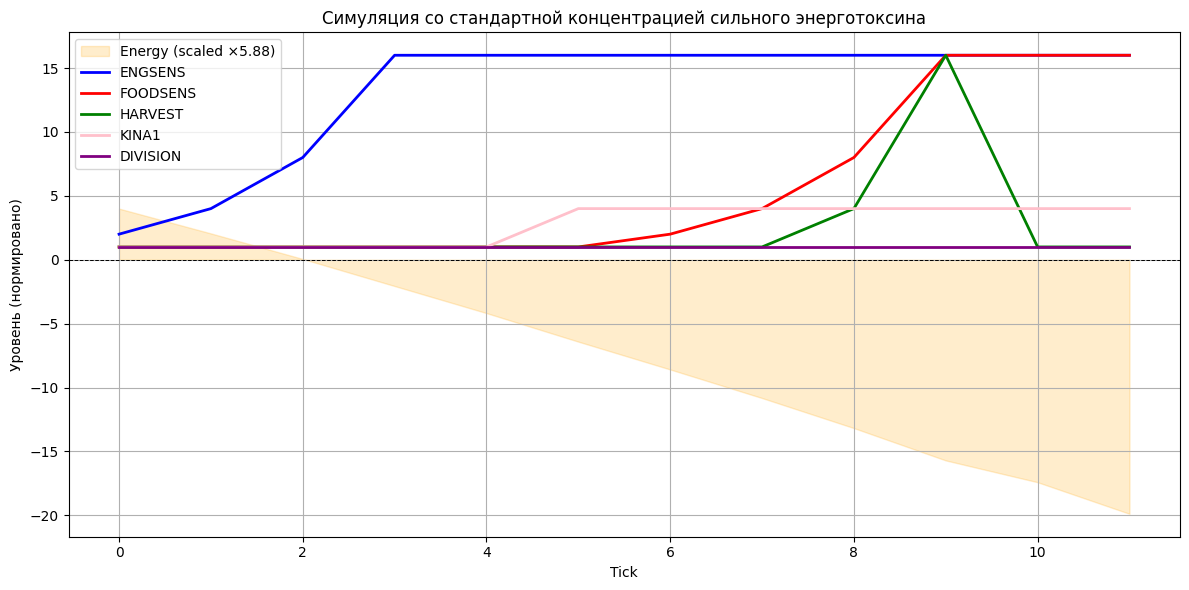

In [9]:
plot_gene_dynamics(df.iloc[:250, :], title="Симуляция со стандартной концентрацией сильного энерготоксина",
                   genes={"ENGSENS": "blue", 
                          "FOODSENS": "red", 
                          "HARVEST": "green",
                          "KINA1": "pink",
                          "DIVISION": "purple"})

In [10]:
# Reduced concentration of energy toxin
df = simulate_cell_with_proteins_and_rna(
    ticks=250,
    initial_food=1.0,
    initial_energy=1.0,
    energy_cost=0.003,
    toxins={"Energotoxin": (-1, ("energy", 0.3)), 
           "RNAtoxin": (0, ("TPM", 0.0))
           },
    receptors={
        "ENGSENS": (12, "qual", "av", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINA1 == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
    },
    
    metabolism={
        "HARVEST":    (2,  "quan", "st", "st", ["Food <= 1", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.008)),
    },
    
    kinases={
        "KINA1":   (3, "qual", "st", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > -1", "DIVISION == 'active'"], False),
    },
    
    cell_cycle={
        "CDK1":    (3,  "qual", "wk", "wk", ["Energy >= 1.5"], ["DIVISION == 'active'"], False),
    },
    
    division={
        "DIVISION":(15, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)

df

,Tick,Food,Energotoxin,RNAtoxin,Energy,ENGSENS,FOODSENS,HARVEST,KINA1,CDK1,DIVISION
0,0,1.0,-1,0,0.82,2.0,1.0,1.0,1.0,1.0,1.0
1,1,1.0,-1,0,0.63,4.0,1.0,1.0,1.0,1.0,1.0
2,2,1.0,-1,0,0.43,8.0,1.0,1.0,1.0,1.0,1.0
3,3,1.0,-1,0,0.20,16.0,1.0,1.0,1.0,1.0,1.0
4,4,1.0,-1,0,-0.02,16.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
245,245,1.0,-1,0,0.76,16.0,1.0,64.0,1.0,1.0,1.0
246,246,1.0,-1,0,0.86,16.0,1.0,64.0,1.0,1.0,1.0
247,247,1.0,-1,0,0.96,16.0,1.0,64.0,1.0,1.0,1.0
248,248,1.0,-1,0,1.06,16.0,1.0,64.0,1.0,1.0,1.0


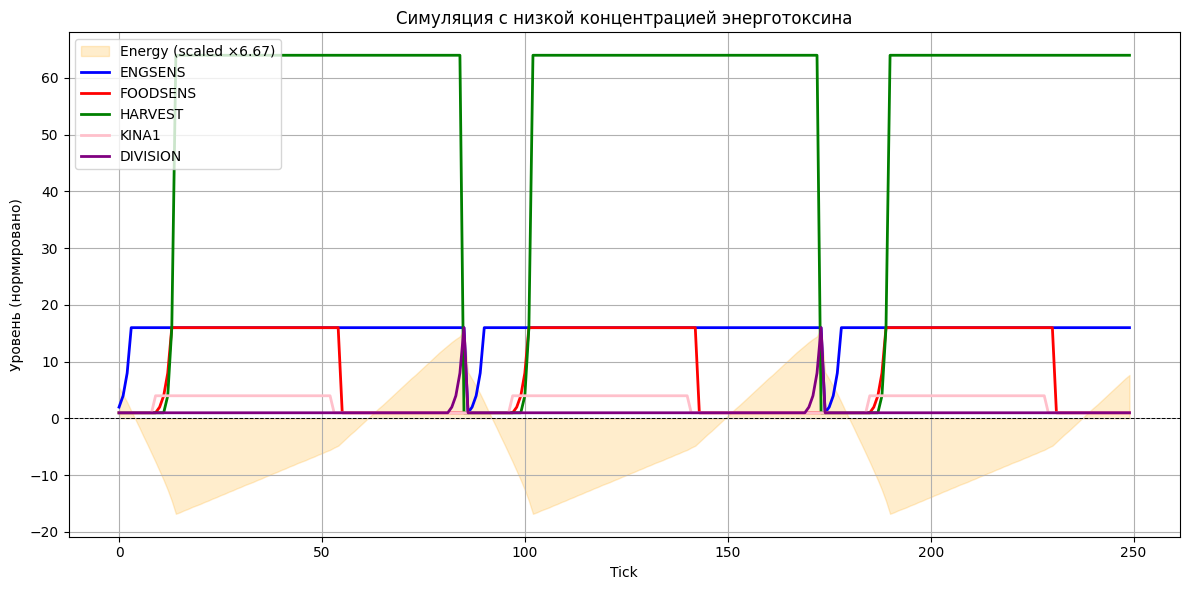

In [11]:
plot_gene_dynamics(df.iloc[:250, :], title="Low energy toxin simulation",
                   genes={"ENGSENS": "blue", 
                          "FOODSENS": "red", 
                          "HARVEST": "green",
                          "KINA1": "pink",
                          "DIVISION": "purple"})

In [12]:
# Reduced concentration of energy toxin and transcription inhibitor
df = simulate_cell_with_proteins_and_rna(
    ticks=250,
    initial_food=1.0,
    initial_energy=1.0,
    energy_cost=0.003,
    toxins={"Energotoxin": (-1, ("energy", 0.3)), 
           "RNAtoxin": (-1, ("TPM", 0.1))
           },
    receptors={
        "ENGSENS": (12, "qual", "av", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINA1 == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
    },
    
    metabolism={
        "HARVEST":    (2,  "quan", "st", "st", ["Food <= 1", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.008)),
    },
    
    kinases={
        "KINA1":   (3, "qual", "st", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > -1", "DIVISION == 'active'"], False),
    },
    
    cell_cycle={
        "CDK1":    (3,  "qual", "wk", "wk", ["Energy >= 1.5"], ["DIVISION == 'active'"], False),
    },
    
    division={
        "DIVISION":(15, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)

df

Клетка погибла на такте 135, energy=-3.27


,Tick,Food,Energotoxin,RNAtoxin,Energy,ENGSENS,FOODSENS,HARVEST,KINA1,CDK1,DIVISION
0,0,1.0,-1,-1,0.82,1.892423,1.000000,1.000000,1.000000,1.0,1.0
1,1,1.0,-1,-1,0.63,3.581266,1.000000,1.000000,1.000000,1.0,1.0
2,2,1.0,-1,-1,0.43,6.777273,1.000000,1.000000,1.000000,1.0,1.0
3,3,1.0,-1,-1,0.22,12.825469,1.000000,1.000000,1.000000,1.0,1.0
4,4,1.0,-1,-1,-0.00,15.139387,1.000000,1.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
131,131,1.0,-1,-1,-2.56,15.139387,15.139387,14.325066,3.784847,1.0,1.0
132,132,1.0,-1,-1,-2.88,15.139387,15.139387,54.218180,3.784847,1.0,1.0
133,133,1.0,-1,-1,-2.72,15.139387,15.139387,1.000000,3.784847,1.0,1.0
134,134,1.0,-1,-1,-3.00,15.139387,15.139387,3.784847,3.784847,1.0,1.0


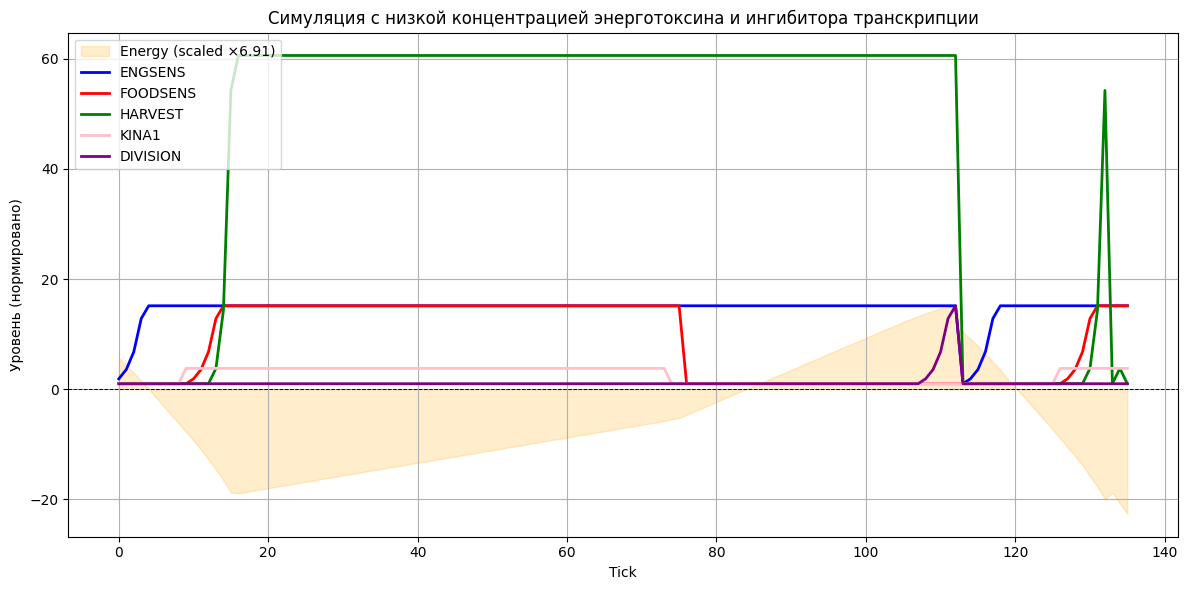

In [13]:
plot_gene_dynamics(df.iloc[:250, :], title="Simulation with low concentration of energotoxin and transcription inhibitor",
                   genes={"ENGSENS": "blue", 
                          "FOODSENS": "red", 
                          "HARVEST": "green",
                          "KINA1": "pink",
                          "DIVISION": "purple"})